In [1]:
# Notebook 출력설정
# 주요 라이브러리 임포트

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams["figure.figsize"] = (15,5)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['axes.grid'] = True
import seaborn as sns

In [2]:
# 원본 데이터셋 로드
dir_dataset = "C:/Users/0stix/Datasets/"
name_project = '2203-dacon-abalone'
df_train = pd.read_csv(dir_dataset+name_project+'/train.csv')
df_test = pd.read_csv(dir_dataset+name_project+'/test.csv')
df_sub = pd.read_csv(dir_dataset+name_project+'/sample_submission.csv')

len_train = len(df_train)
df_all = pd.concat([df_train, df_test], axis=0)
target = 'Target'

FileNotFoundError: [Errno 2] No such file or directory: 'C:/Users/0stix/Datasets/2203-dacon-abalone/train.csv'

In [74]:
eta_ = 0.00001

df_v0 = pd.DataFrame()

df_v0 = pd.get_dummies(df_all['Gender'].astype('category').cat.codes, prefix='G')

df_v0['L'] = df_all['Lenght']
df_v0['D'] = df_all['Diameter']
df_v0['H'] = df_all['Height']

df_v0['V'] = df_v0['L'] * df_v0['D'] * df_v0['H']
df_v0['L/D'] = df_v0['L'] / (df_v0['D'] + eta_)
df_v0['D/H'] = df_v0['D'] / (df_v0['H'] + eta_)
df_v0['H/L'] = df_v0['H'] / (df_v0['L'] + eta_)

df_v0['wWl'] = df_all['Whole Weight']
df_v0['wSk'] = df_all['Shucked Weight']
df_v0['wVs'] = df_all['Viscra Weight']
df_v0['wSl'] = df_all['Shell Weight']
df_v0['wEt'] = df_v0['wWl'] - (df_v0['wSk'] + df_v0['wVs'] + df_v0['wSl'])

df_v0['rSk'] = df_v0['wSk'] / (df_v0['wWl'] + eta_)
df_v0['rVs'] = df_v0['wVs'] / (df_v0['wWl'] + eta_)
df_v0['rSl'] = df_v0['wSl'] / (df_v0['wWl'] + eta_)

df_v0['wWl/V'] = df_v0['wWl'] / (df_v0['V'] + eta_)
# df_v0['wSk/V'] = df_v0['wSk'] / df_v0['V']
# df_v0['wVs/V'] = df_v0['wVs'] / df_v0['V']
df_v0['wSl/V'] = df_v0['wSl'] / (df_v0['V'] + eta_)
df_v0['wEt/V'] = df_v0['wEt'] / (df_v0['V'] + eta_)

df_v0['rSk/V'] = df_v0['rSk'] / (df_v0['V'] + eta_)
df_v0['rVs/V'] = df_v0['rVs'] / (df_v0['V'] + eta_)
# df_v0['rSl/V'] = df_v0['rSl'] / df_v0['V']

# df_v0['rSk/L'] = df_v0['rSk'] / df_v0['L']
# df_v0['rSk/D'] = df_v0['rSk'] / df_v0['D']
# df_v0['rSk/H'] = df_v0['rSk'] / df_v0['H']
# df_v0['rSk/D/H'] = df_v0['rSk'] / df_v0['D/H']


# df_v0[target] = df_all[target] + .5
df_v0[target] = df_all[target]

In [75]:
df_v0.drop(target, axis=1).corrwith(df_v0[target]).abs()

G_0      0.241170
G_1      0.437064
G_2      0.193054
L        0.543789
D        0.567933
H        0.604654
V        0.548341
L/D      0.387792
D/H      0.239966
H/L      0.377216
wWl      0.538404
wSk      0.420126
wVs      0.497283
wSl      0.625819
wEt      0.509678
rSk      0.188242
rVs      0.092707
rSl      0.167282
wWl/V    0.175033
wSl/V    0.010841
wEt/V    0.127347
rSk/V    0.361384
rVs/V    0.336601
dtype: float64

In [76]:
def tr_te_split(df_all, len_train, target):
    X = df_all.drop(target, axis=1)
    y = df_all[target]
    X_tr = X[:len_train]
    y_tr = y[:len_train]
    X_te = X[len_train:]
    return X_tr, y_tr, X_te

In [77]:
# 고속 데이터셋 평가
def eval_df(X, y, lst_model):
    from sklearn.model_selection import cross_val_score
    
    grd_score = []
    for model_ in lst_model:
        grd_score.append(cross_val_score(
            model_, 
            X, 
            y, 
            cv=5, 
            scoring="neg_mean_absolute_error", 
            n_jobs=-1))
        
    return grd_score

In [78]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

lst_model = [
    # XGBRegressor(),
    CatBoostRegressor(silent=True)
]

X_train, y_train, X_test = tr_te_split(df_v0, len_train, target)
# X_train.shape, y_train.shape, X_test.shape
# grd_score = eval_df(X_trrain, y_train, lst_model)

In [79]:
import optuna
from optuna.samplers import TPESampler
optuna.logging.set_verbosity(optuna.logging.CRITICAL)

In [80]:
import numpy as np

def NMAE_(true, pred):
    mae = np.mean(np.abs(true-pred))
    score = mae / np.mean(np.abs(true))
    return score

In [81]:
VERBOSE_ = 0
RANDOM_STATE = 0
EVAL_METRIC = 'mae'
SCORING_ = NMAE_

# XGBOOST

In [82]:
# xgboost
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBRegressor
import time

early_stopping_rounds = 100

def obj_xgr(trial_):
    lst_param = {
        "random_state" : RANDOM_STATE,
        "eval_metric" : EVAL_METRIC,
        # ------------------------------------------------------------
        # Learning_rate: 성능고려해서 조절 - 낮을수록 고득점 유리
        "learning_rate" : 0.05,
        # "learning_rate" : trial_.suggest_loguniform("learning_rate", 0.0001, 0.3),
        
        # "n_estimators": trial_.suggest_int("n_estimators", 50, 1000),
        "n_estimators": 10000,
        
        # "Max_depth": 01
        "max_depth":trial_.suggest_int("max_depth", 2, 10),
        
        # "Max_leaves": 02
        "max_leaves":trial_.suggest_int("max_leaves", 32, 1024),
        
        # "Row_sampling", "Col_sampling": 03
        "subsample": 0.7,
        # "subsample":trial_.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": 0.7,
        # "colsample_bytree":trial_.suggest_float("colsample_bytree", 0.5, 1.0),
        
        
        # "booster": trial_.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial_.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial_.suggest_loguniform("alpha", 1e-8, 1.0),
        
        # ------------------------------------------------------------
        # "Tree_method":
        # "tree_method" : "gpu_hist",
        # "tree_method" : trial_.suggest_categorical("tree_method", ["exact", "approx", "hist", "gpu_hist"]),
        
        # ------------------------------------------------------------
        # 'reg_alpha': 2.9735993984217104,
        # 'reg_lambda': 2.214625977393439,
        # 'scale_pos_weight': 0.9,
        # 'gamma': 0.5
    }
    
    # if lst_param["booster"] == "gbtree" or lst_param["booster"] == "dart":
        # lst_param["max_depth"] = trial_.suggest_int("max_depth", 1, 9)
        # lst_param["eta"] = trial_.suggest_loguniform("eta", 1e-8, 1.0)
        # lst_param["gamma"] = trial_.suggest_loguniform("gamma", 1e-8, 1.0)
        # lst_param["grow_policy"] = trial_.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    # if lst_param["booster"] == "dart":
    #     lst_param["sample_type"] = trial_.suggest_categorical("sample_type", ["uniform", "weighted"])
    #     lst_param["normalize_type"] = trial_.suggest_categorical("normalize_type", ["tree", "forest"])
    #     lst_param["rate_drop"] = trial_.suggest_loguniform("rate_drop", 1e-8, 1.0)
    #     lst_param["skip_drop"] = trial_.suggest_loguniform("skip_drop", 1e-8, 1.0)
    
    time_s = time.time()
    lst_score = []
    
    cv_ = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    for indice_tr, indice_va in cv_.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[indice_tr], X_train.iloc[indice_va]
        y_tr, y_va = y_train.iloc[indice_tr], y_train.iloc[indice_va]
        model_ = XGBRegressor(**lst_param)
        model_.fit(
            X_tr,
            y_tr,
            eval_set = [(X_va, y_va)],
            eval_metric=EVAL_METRIC,
            early_stopping_rounds=early_stopping_rounds,
            verbose=VERBOSE_,
        )
        p_va = model_.predict(X_va)
        lst_score.append(SCORING_(y_va, p_va))
    score_va = np.mean(lst_score)
    
    if VERBOSE_:
        print("VS: {:>6.4f}, ET: {:>6.2f}".format(score_va, time.time() - time_s))

    return score_va

In [83]:
TRIALS = 100
TIMEOUT = 1200

sampler_ = TPESampler()
study_ = optuna.create_study(
    direction = 'minimize',
    sampler = sampler_,
)
study_.optimize(obj_xgr, n_trials=TRIALS, timeout=TIMEOUT, show_progress_bar=1)
print(study_.best_value)
print(study_.best_trial.params)

  0%|          | 0/100 [00:00<?, ?it/s]

0.14827746906961708
{'max_depth': 3, 'max_leaves': 899, 'lambda': 0.46265991819794877, 'alpha': 5.9009057497927356e-08}


In [84]:
from sklearn.model_selection import train_test_split

X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.3, random_state=RANDOM_STATE)
model_tmp = XGBRegressor(**study_.best_params, n_estimators=30000)
model_tmp.fit(X_tr, y_tr, eval_set=[(X_va, y_va)], early_stopping_rounds=early_stopping_rounds,verbose=0)

# model_ = XGBRegressor(**study_.best_params, n_estimators=model_tmp.get_booster().best_ntree_limit, verbose=VERBOSE_)
model_va = XGBRegressor(**study_.best_params, n_estimators=model_tmp.get_booster().best_ntree_limit)
model_va.fit(X_tr, y_tr)
p_va = model_va.predict(X_va)
print(SCORING_(y_va, p_va))

0.15168466973259284


In [85]:
model_ = XGBRegressor(**study_.best_params, n_estimators=model_tmp.get_booster().best_ntree_limit)
model_.fit(X_train, y_train)
p_test_xgb = model_.predict(X_test)

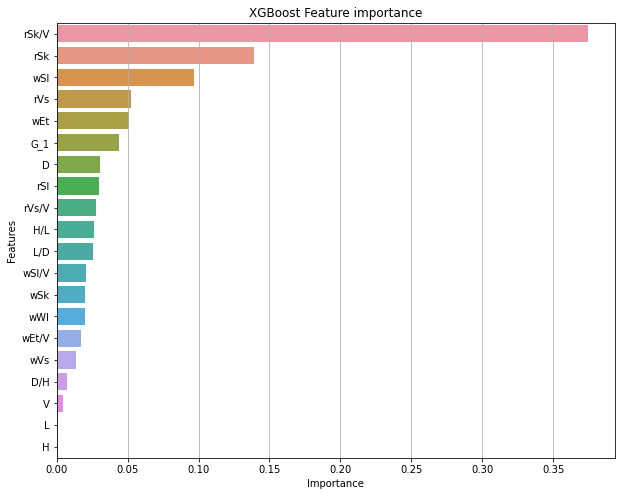

In [87]:
FI=pd.DataFrame({'Features':df_v0.columns[:-1],'Importance':model_.feature_importances_})
FI=FI.sort_values(by='Importance',ascending=False)[:20]
#plot
plt.figure(figsize=(10,8))
sns.barplot(x=FI.Importance,y=FI.Features).set_title('XGBoost Feature importance')
plt.show()

# NGBOOST

In [100]:
# ngboost
from sklearn.model_selection import StratifiedKFold
from ngboost import NGBRegressor
import time

early_stopping_rounds = 100

def obj_ngr(trial_):
    lst_param = {
        "random_state" : RANDOM_STATE,
        # "eval_metric" : EVAL_METRIC,
        # ------------------------------------------------------------
#         # Learning_rate: 성능고려해서 조절 - 낮을수록 고득점 유리
        "learning_rate" : 0.05,
#         # "learning_rate" : trial_.suggest_loguniform("learning_rate", 0.0001, 0.3),
        
#         # "n_estimators": trial_.suggest_int("n_estimators", 50, 1000),
        "n_estimators": 10000,
        
        "verbose": False,
        
#         # "Max_depth": 01
#         "max_depth":trial_.suggest_int("max_depth", 2, 10),
        
#         # "Max_leaves": 02
#         "max_leaves":trial_.suggest_int("max_leaves", 32, 1024),
        
#         # "Row_sampling", "Col_sampling": 03
        "col_sample": 0.7
#         "subsample": 0.7,
#         # "subsample":trial_.suggest_float("subsample", 0.5, 1.0),

#         # "col_sample":trial_.suggest_float("col_sample", 0.5, 1.0),
        
        
#         # "booster": trial_.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
#         "lambda": trial_.suggest_loguniform("lambda", 1e-8, 1.0),
#         "alpha": trial_.suggest_loguniform("alpha", 1e-8, 1.0),
        
        # ------------------------------------------------------------

    }
    

    time_s = time.time()
    lst_score = []
    
    cv_ = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    for indice_tr, indice_va in cv_.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[indice_tr], X_train.iloc[indice_va]
        y_tr, y_va = y_train.iloc[indice_tr], y_train.iloc[indice_va]
        model_ = NGBRegressor(**lst_param)
        model_.fit(
            X_tr,
            y_tr,
            X_val=X_va,
            Y_val=y_va,
            # eval_set = [(X_va, y_va)],
            # eval_metric=EVAL_METRIC,
            early_stopping_rounds=early_stopping_rounds,
            # verbose=VERBOSE_,
        )
        p_va = model_.predict(X_va)
        lst_score.append(SCORING_(y_va, p_va))
    score_va = np.mean(lst_score)
    
    if VERBOSE_:
        print("VS: {:>6.4f}, ET: {:>6.2f}".format(score_va, time.time() - time_s))

    return score_va

In [101]:
TRIALS = 1
TIMEOUT = 1200

sampler_ = TPESampler()
study_ = optuna.create_study(
    direction = 'minimize',
    sampler = sampler_,
)
study_.optimize(obj_ngr, n_trials=TRIALS, timeout=TIMEOUT, show_progress_bar=1)
print(study_.best_value)

  0%|          | 0/1 [00:00<?, ?it/s]

0.15580566673955382


In [102]:
from sklearn.model_selection import train_test_split

X_tr, X_va, y_tr, y_va = train_test_split(X_train, y_train, test_size=0.3, random_state=RANDOM_STATE)
model_tmp = NGBRegressor(**study_.best_params, n_estimators=30000)
model_tmp.fit(X_tr, y_tr, X_val=X_va, Y_val=y_va, early_stopping_rounds=early_stopping_rounds)

model_va = NGBRegressor(**study_.best_params, n_estimators=model_tmp.best_val_loss_itr)
model_va.fit(X_tr, y_tr)
p_va = model_va.predict(X_va)
print(SCORING_(y_va, p_va))

[iter 0] loss=2.6057 val_loss=2.5358 scale=1.0000 norm=2.5090
[iter 100] loss=2.1214 val_loss=2.2086 scale=1.0000 norm=1.7065
[iter 200] loss=1.8483 val_loss=2.1152 scale=2.0000 norm=2.8735
== Early stopping achieved.
== Best iteration / VAL186 (val_loss=2.1139)
[iter 0] loss=2.6057 val_loss=0.0000 scale=1.0000 norm=2.5090
[iter 100] loss=2.1214 val_loss=0.0000 scale=1.0000 norm=1.7065
0.15852789788791197


In [91]:
model_ = NGBRegressor(**study_.best_params, n_estimators=model_tmp.best_val_loss_itr)
model_.fit(X_train, y_train)
p_test_ngb = model_.predict(X_test)

[iter 0] loss=2.5863 val_loss=0.0000 scale=1.0000 norm=2.4917
[iter 100] loss=2.1108 val_loss=0.0000 scale=1.0000 norm=1.6761


# CATBOOST

In [ ]:
# xbgoost
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor
import time

early_stopping_rounds = 100

def obj_xgr(trial_):
    lst_param = {
        "random_state" : RANDOM_STATE,
        "eval_metric" : EVAL_METRIC,
        # ------------------------------------------------------------
        # Learning_rate: 성능고려해서 조절 - 낮을수록 고득점 유리
        "learning_rate" : 0.05,
        # "learning_rate" : trial_.suggest_loguniform("learning_rate", 0.0001, 0.3),
        
        # "n_estimators": trial_.suggest_int("n_estimators", 50, 1000),
        "n_estimators": 10000,
        
        # "Max_depth": 01
        "max_depth":trial_.suggest_int("max_depth", 2, 10),
        
        # "Max_leaves": 02
        "max_leaves":trial_.suggest_int("max_leaves", 32, 1024),
        
        # "Row_sampling", "Col_sampling": 03
        "subsample": 0.7,
        # "subsample":trial_.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": 0.7,
        # "colsample_bytree":trial_.suggest_float("colsample_bytree", 0.5, 1.0),
        
        
        # "booster": trial_.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial_.suggest_loguniform("lambda", 1e-8, 1.0),
        "alpha": trial_.suggest_loguniform("alpha", 1e-8, 1.0),
        
        # ------------------------------------------------------------
        # "Tree_method":
        # "tree_method" : "gpu_hist",
        # "tree_method" : trial_.suggest_categorical("tree_method", ["exact", "approx", "hist", "gpu_hist"]),
        
        # ------------------------------------------------------------
        # 'reg_alpha': 2.9735993984217104,
        # 'reg_lambda': 2.214625977393439,
        # 'scale_pos_weight': 0.9,
        # 'gamma': 0.5
    }
    
    # if lst_param["booster"] == "gbtree" or lst_param["booster"] == "dart":
        # lst_param["max_depth"] = trial_.suggest_int("max_depth", 1, 9)
        # lst_param["eta"] = trial_.suggest_loguniform("eta", 1e-8, 1.0)
        # lst_param["gamma"] = trial_.suggest_loguniform("gamma", 1e-8, 1.0)
        # lst_param["grow_policy"] = trial_.suggest_categorical("grow_policy", ["depthwise", "lossguide"])
    # if lst_param["booster"] == "dart":
    #     lst_param["sample_type"] = trial_.suggest_categorical("sample_type", ["uniform", "weighted"])
    #     lst_param["normalize_type"] = trial_.suggest_categorical("normalize_type", ["tree", "forest"])
    #     lst_param["rate_drop"] = trial_.suggest_loguniform("rate_drop", 1e-8, 1.0)
    #     lst_param["skip_drop"] = trial_.suggest_loguniform("skip_drop", 1e-8, 1.0)
    
    time_s = time.time()
    lst_score = []
    
    cv_ = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    for indice_tr, indice_va in cv_.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[indice_tr], X_train.iloc[indice_va]
        y_tr, y_va = y_train.iloc[indice_tr], y_train.iloc[indice_va]
        model_ = CatBoostRegressor(**lst_param)
        model_.fit(
            X_tr,
            y_tr,
            eval_set = [(X_va, y_va)],
            eval_metric=EVAL_METRIC,
            early_stopping_rounds=early_stopping_rounds,
            verbose=VERBOSE_,
        )
        p_va = model_.predict(X_va)
        lst_score.append(SCORING_(y_va, p_va))
    score_va = np.mean(lst_score)
    
    if VERBOSE_:
        print("VS: {:>6.4f}, ET: {:>6.2f}".format(score_va, time.time() - time_s))

    return score_va

In [ ]:
TRIALS = 100
TIMEOUT = 1200

sampler_ = TPESampler()
study_ = optuna.create_study(
    direction = 'minimize',
    sampler = sampler_,
)
study_.optimize(obj_xgr, n_trials=TRIALS, timeout=TIMEOUT, show_progress_bar=1)
print(study_.best_value)
print(study_.best_trial.params)

In [ ]:
model_ = XGBRegressor(**study_.best_params, n_estimators=model_tmp.get_booster().best_ntree_limit)
model_.fit(X_train, y_train)
p_test_xgb = model_.predict(X_test)

# SOFT VOTING

In [95]:
# df_sub[target] = .5 * p_test_xgb + .5 * p_test_ngb
# df_sub[target] = 0 * p_test_xgb + 1 * p_test_ngb
# df_sub[target] = 1 * p_test_xgb + 0 * p_test_ngb


import datetime
now = datetime.datetime.now()
str_datetime = now.strftime("%y%m%d_%H%M%S")
df_sub.to_csv(dir_dataset+'submission-'+name_project+'-'+str_datetime+'.csv', index = 0)

In [93]:
df_sub

,id,Target
0,1,11.575770
1,2,13.431096
2,3,6.316694
3,4,10.871872
4,5,10.045742
...,...,...
2919,2920,4.433254
2920,2921,7.542690
2921,2922,9.201646
2922,2923,10.051076


In [ ]:
# catboost
from sklearn.model_selection import StratifiedKFold
from catboost import CatBoostRegressor
import time

early_stopping_rounds = 30

def obj_cbr(trial_):
    lst_param = {
        
    }
    
    cv_ = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    
    lst_score =[]
    for indice_tr, indice_va in cv_.split(X_train, y_train):
        X_tr, X_va = X_train.iloc[indice_tr]
        y_tr, y_va = y_train.iloc[indice_va] 
    
        model_ = CatBoostRegressor(**lst_param)
        model_.fit(
            X_tr,
            y_tr,
            eval_set = [(X_va, y_va)],
            eval_metric=EVAL_METRIC,
            early_stopping_rounds=early_stopping_rounds
            verbose=VERBOSE_
        )
        y_pr = model.predict_proba(X_va)[:,1]
        lst_score.append(SCORE_(y_va, y_pr))
    score_va = mean(lst_score)
    return score_va

In [35]:
from sklearn.metrics import mean_absolute_error as mae
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import time

def objective(trial):
    params = {
        "random_state":trial.suggest_categorical("random_state", [0]),
        'learning_rate' : trial.suggest_loguniform('learning_rate', 0.0001, 0.3),
        'bagging_temperature' :trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        # "n_estimators": trial.suggest_int("n_estimators", 50, 1000),
        "n_estimators": 1000,
        "max_depth":trial.suggest_int("max_depth", 2, 9),
        'random_strength' :trial.suggest_int('random_strength', 0, 100),
        "l2_leaf_reg":trial.suggest_float("l2_leaf_reg",1e-8,3e-5),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
        # 'od_type': trial.suggest_categorical('od_type', ['IncToDec', 'Iter']),
        # 'task_type': trial.suggest_categorical('task_type', ['GPU']),
        'loss_function': trial.suggest_categorical('loss_function', ['MAE']),
        'eval_metric': trial.suggest_categorical('eval_metric', ['MAE'])
    }
    
    model = CatBoostRegressor(**params)
    
    time_s = time.time()
    # for key_, value_ in params.items():
    #     print(key_, value_)
        
    X_train_tmp, X_valid_tmp, y_train_tmp, y_valid_tmp = train_test_split(X_tr, y_tr, test_size=0.3, random_state=42)
    model.fit(
        X_train_tmp, y_train_tmp,
        eval_set=[(X_valid_tmp, y_valid_tmp)],
        early_stopping_rounds=50, 
        verbose=0,
    )
        
    y_train_pred = model.predict(X_train_tmp)
    y_valid_pred = model.predict(X_valid_tmp)
    train_mae = mae(y_train_tmp, y_train_pred)
    valid_mae = mae(y_valid_tmp, y_valid_pred)
    
    # print(f'MAE of Train: {train_mae}, MAE of Validation: {valid_mae}', time.time() - time_s)
    # print(f'MAE of Train: {train_mae}, MAE of Validation: {valid_mae}', time.time() - time_s)
    print("MAE Tr: {:5.3f}, MAE Va: {:5.3f}, ET: {:06.1f}".format(train_mae, valid_mae, time.time() - time_s))
    
    # print()
    
    return valid_mae

In [36]:
TRIALS = 100
TIMEOUT = 1200

sampler_ = TPESampler()
study_ = optuna.create_study(
    study_name = 'cat_parameter_opt',
    direction = 'minimize',
    sampler = sampler_,
)
study_.optimize(objective, n_trials=TRIALS, timeout=TIMEOUT, show_progress_bar=0, )
print(study_.best_value, study_.best_trial.params)

MAE Tr: 1.418, MAE Va: 1.465, ET: 0000.1
MAE Tr: 1.989, MAE Va: 1.872, ET: 0001.0
MAE Tr: 2.259, MAE Va: 2.112, ET: 0001.9
MAE Tr: 2.026, MAE Va: 1.936, ET: 0011.0
MAE Tr: 1.441, MAE Va: 1.425, ET: 0000.1
MAE Tr: 1.429, MAE Va: 1.424, ET: 0000.3
MAE Tr: 2.299, MAE Va: 2.148, ET: 0002.6
MAE Tr: 1.368, MAE Va: 1.440, ET: 0002.2
MAE Tr: 0.995, MAE Va: 1.418, ET: 0023.4
MAE Tr: 1.489, MAE Va: 1.487, ET: 0000.1
MAE Tr: 1.007, MAE Va: 1.412, ET: 0020.8
MAE Tr: 1.000, MAE Va: 1.420, ET: 0017.9
MAE Tr: 1.387, MAE Va: 1.492, ET: 0005.1
MAE Tr: 1.049, MAE Va: 1.406, ET: 0002.5
MAE Tr: 1.091, MAE Va: 1.424, ET: 0001.0
MAE Tr: 1.040, MAE Va: 1.409, ET: 0003.8
MAE Tr: 1.281, MAE Va: 1.421, ET: 0000.7
MAE Tr: 1.146, MAE Va: 1.421, ET: 0000.6
MAE Tr: 1.115, MAE Va: 1.416, ET: 0001.8
MAE Tr: 1.177, MAE Va: 1.419, ET: 0001.0
MAE Tr: 1.729, MAE Va: 1.659, ET: 0001.3
MAE Tr: 1.040, MAE Va: 1.407, ET: 0004.2
MAE Tr: 1.066, MAE Va: 1.416, ET: 0003.0
MAE Tr: 1.072, MAE Va: 1.404, ET: 0001.0
MAE Tr: 1.184, M